<a href="https://colab.research.google.com/github/razzlestorm/DS-Unit-2-Regression-Classification/blob/master/module2/Jerimiah_Willhite_assignment_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Do the [Plotly Dash](https://dash.plot.ly/) Tutorial, Parts 1 & 2.
- [ ] Add your own stretch goal(s) !

In [91]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd
from ipywidgets import interact
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objs as go





# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [189]:
#converting created column to datetime

df['created'] = pd.to_datetime(df['created'])

print(df.shape)
df.head()

(48817, 34)


,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [190]:
#Adding a new feature, length of description
df['desc_length'] = df['description'].str.len()

#remapping interest level to ints for plotly plot
interest_dict = {'low': 1, 'medium': 2, 'high': 3}
df['interest_level'] = df['interest_level'].map(interest_dict)
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,desc_length
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,588.0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,3,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,691.0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,492.0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,479.0


In [0]:
df['desc_length'] = df['desc_length'].fillna(method='pad')

In [192]:
df['desc_length'].isna().sum()

0

In [193]:
#visualize data and see features in scatter plot
'''px.scatter(df, 
              x='desc_length',
              y= 'price',
                color='interest_level',

             title = 'Scattered')'''

fig = go.Figure(data=go.Scattergl(
    x = df['desc_length'],
    y = df['price'],
    mode='markers',
    marker=dict(
        color=df['interest_level'],
        colorscale='Portland', 
        opacity=0.7,
        line=dict(color='LightGray', width=1)
            ),
    )
)

fig.show()

#price seems to be more important to interest level than length of description, but let's see what the model says

In [203]:
#checking if it can predict length of description based on interest level and price
model = LinearRegression()

features = ['interest_level', 'price']
target = 'desc_length'

X = df[features]
y = df[target]

model.fit(X, y)

print(f'{model.intercept_}, {model.coef_[0]}, {model.coef_[1]:.10f}')
print(X.size, y.size)

412.34403798942265, 47.10796809602009, 0.0398179223
97634 48817


In [0]:
y_pred = model.predict(X)
df['Predicted'] = y_pred
df['Error'] = y_pred - y
df

In [205]:
#MEAN ABSOLUTE ERROR (MAE)
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y, y_pred)

284.0427520838655

In [207]:
guesses = [y.mean()] * len(y)
mean_absolute_error(y, guesses)

290.43182816779165

In [0]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_squared_errors(df, feature, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

Mean Squared Error: 2134677.1525493166
Root Mean Squared Error: 1461.0534393201765
Mean Absolute Error: 1243.789704406252
R^2: -13.529908086866708


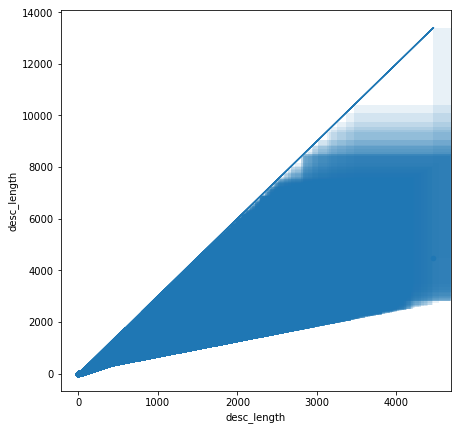

In [213]:
feature = 'desc_length'
regression_squared_errors(df, feature, target, m=3, b=4)